# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
''';

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info['missing_or_unknown']

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [8]:
data = azdias.copy()

In [9]:
#converting string list to list of strings
miss_list = []
for i in  feat_info['missing_or_unknown']:
    miss_list.append(i.strip('[]').split(',') )

In [10]:
columns = data.columns
for col,miss in zip(columns,miss_list):
    #skip empty missing feature columns
    if miss[0] != '':
        for i in miss:
            #print(i)
            #check if the string is a number
            if i.isnumeric() or i.lstrip('-').isnumeric():
                i=int(i)
            #change missing features to nans
            data.loc[data[col]==i, col] = np.nan
    

In [11]:
data.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILI

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
hist_df = pd.DataFrame()
columns = data.columns
for column in columns:
    hist_df[column]=[data[column].isnull().sum()/(data[column].isnull().sum()+data[column].count())]
    

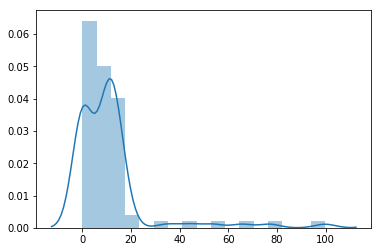

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

prcnt_data = ((data.isnull().sum()/(data.isnull().sum()+data.count()))*100).sort_values(ascending=False)

sns.distplot(prcnt_data);

In [15]:
# Investigate patterns in the amount of missing data in each column :


to_drop=[]
for i in range(len(prcnt_data)):
    if prcnt_data[i] > 25:
        to_drop.append(prcnt_data.index[i])
#prcnt_data[0], prcnt_data.index[0]

In [16]:
#columns that have over 25% nans
to_drop

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
data.drop(labels=to_drop, axis=1, inplace=True)

In [18]:
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
The columns with missing data are encapsulated in the to_drop list. The missing values in the columns seem to be due to poor survey questions. The answers are too narrow and leave little room to capture everyone's response. They were all subsequently removed. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
row_miss = data.isnull().sum(axis=1)

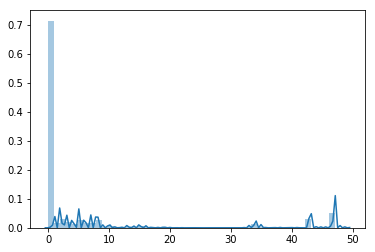

In [20]:
sns.distplot(row_miss);

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
over10=[]
under10=[]
for idx,i in enumerate(row_miss):
    if i >=10:
        over10.append(idx)
    else:
        under10.append(idx)

data_over10 = data.drop(under10, axis=0)
data_under10 = data.drop(over10, axis=0)


In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

columns = ['ALTERSKATEGORIE_GROB','ANREDE_KZ', 'CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_UNAUFFAELLIGER']

def count_plot(columns):
    fig , axs = plt.subplots(len(columns),2, figsize=(15,10))
    for i,cols in enumerate(columns):
    
        sns.countplot(x=cols, data=data_over10, ax=axs[i,0])
        axs[i,0].set_title('Over 10 NaNs')
        axs[i,0].set_ylabel('Count',size='large')
        axs[i,0].set_xlabel(xlabel=cols,size='large')
        
        sns.countplot(x=cols, data=data_under10,ax=axs[i,1])
        axs[i,1].set_title('Under 10 NaNs')
        axs[i,1].set_ylabel('Count',size='large')
        axs[i,1].set_xlabel(xlabel=cols,size='large')
    
        plt.subplots_adjust(left=0.1,
                    bottom=0.001, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.8)

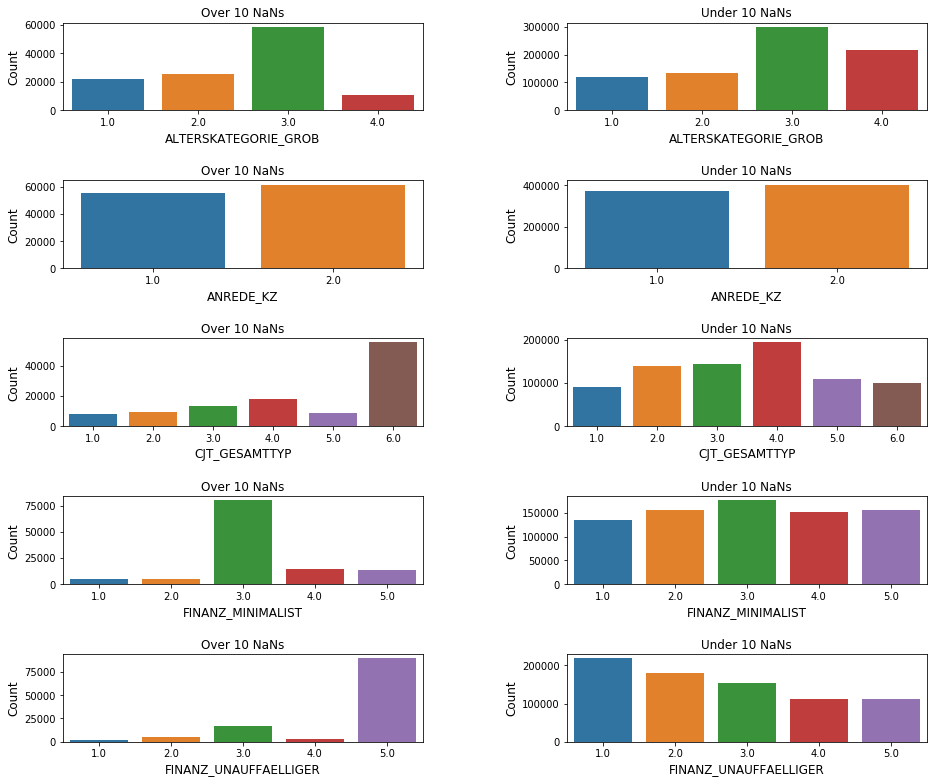

In [23]:
count_plot(columns)

In [24]:
len(data_under10),len(data_over10)

(774743, 116478)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The missing data in the rows seems to be due to largely concentrated on columns with a low amount of survey options

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info[(feat_info['type']=='categorical') | (feat_info['type']=='mixed')]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]


In [26]:
print('# of Categorical:', len(feat_info[feat_info['type']=='categorical']), '| # of Mixed: ', len(feat_info[feat_info['type']=='mixed']))

# of Categorical: 21 | # of Mixed:  7


In [27]:
cols = feat_info[(feat_info['type']=='categorical')]['attribute'].drop([0 ,40 ,47],axis=0)
binary =[]
multi = []
#creating lists of multi&binary features
for col in cols:
    print(col,' : ',len(data_under10[col].unique()), ' : ',data_under10[col].unique())
    if len(data_under10[col].unique()) == 2:
           binary.append(col)
    else: 
        multi.append(col)

ANREDE_KZ  :  2  :  [ 2.  1.]
CJT_GESAMTTYP  :  6  :  [ 5.  3.  2.  4.  1.  6.]
FINANZTYP  :  6  :  [ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP  :  12  :  [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
GREEN_AVANTGARDE  :  2  :  [0 1]
LP_FAMILIE_FEIN  :  12  :  [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB  :  6  :  [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN  :  10  :  [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.]
LP_STATUS_GROB  :  5  :  [ 1.  2.  4.  5.  3.]
NATIONALITAET_KZ  :  4  :  [  1.   3.   2.  nan]
SHOPPER_TYP  :  5  :  [  3.   2.   1.   0.  nan]
SOHO_KZ  :  2  :  [ 1.  0.]
VERS_TYP  :  3  :  [  2.   1.  nan]
ZABEOTYP  :  6  :  [ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP  :  7  :  [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ  :  2  :  ['W' 'O']
CAMEO_DEUG_2015  :  10  :  ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015  :  45  :  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' na

In [28]:
binary,multi

(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ'],
 ['CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'VERS_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015'])

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for col in binary:
    print(col, " : ", type(data_under10[col][1]))
    
#OST_WEST_KZ must be rencoded but the others are fine

ANREDE_KZ  :  <class 'numpy.float64'>
GREEN_AVANTGARDE  :  <class 'numpy.int64'>
SOHO_KZ  :  <class 'numpy.float64'>
OST_WEST_KZ  :  <class 'str'>


In [30]:
#originally some multi-class variables were going to be kept, but do to the high dimensionality
#of the dataset they were all ultimately dropped
"""keep = []
remove = []
for col in multi:
    print(col, " : ", type(data_under10[col][1]), len(data_under10[col].unique())<=5)
    if len(data_under10[col].unique()) <= 5:
           keep.append(col)
    else:
        remove.append(col)""";

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.

#dropping multi-categorical variables
data_under10.drop(multi,axis=1,inplace=True)

In [32]:
#creating dummy varibles for O and W
data_under10 = data_under10.join(pd.get_dummies(data_under10['OST_WEST_KZ']))

In [33]:
#Dropping old column
data_under10.drop(['OST_WEST_KZ'],axis=1,inplace=True)

In [34]:
data_under10.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0,1
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0,1
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0,1
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0,2.0,...,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

- The OST_WEST_KZ feature was re-encoded with dummy variables for its two possible values: 'O' & 'W'. 
- The multi-class categorical features were dropped as there is already a large amount of dimensions in this dataset


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
'''
PRAEGENDE_JUGENDJAHRE
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)'''

mainstream = [1,3,5,8,10,12,14]
avantgarde = [2,4,6,7,9,11,13,15]

#Mainstream enigneered to 0, Avantgarde engineered to 1
PRAEGENDE_JUGENDJAHRE_MOVEMENT = []
for i in data_under10['PRAEGENDE_JUGENDJAHRE']:
    if i in mainstream:
        PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(0)
    elif i in avantgarde:
        PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(1)
    else:
        PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(np.nan)


In [36]:
#40s:0 ; 50s:1 ; 60s:2 ; 70s:3 ; 80s:4 ; 90s:5

PRAEGENDE_JUGENDJAHRE_DECADES = []
for i in data_under10['PRAEGENDE_JUGENDJAHRE']:
    if ((i == 1) or (i==2)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(0)
    elif ((i==3) or (i==4)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(1)
    elif ((i==5) or (i==6) or (i==7)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(2)
    elif ((i==8) or (i==9)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(3)
    elif ((i==10) or (i==11)or(i==12) or (i==13)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(4)
    elif ((i==14) or (i==15)):
        PRAEGENDE_JUGENDJAHRE_DECADES.append(5)
    else:
        PRAEGENDE_JUGENDJAHRE_DECADES.append(np.nan)

In [37]:
data_under10.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [38]:
data_under10['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT
data_under10['PRAEGENDE_JUGENDJAHRE_DECADES'] = PRAEGENDE_JUGENDJAHRE_DECADES

In [39]:
data_under10.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADES
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0.0,5.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,1,1.0,5.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0.0,3.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0.0,1.0


In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
"""CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement""";

#NaNs were causing issues so converting them to 0's and then back to NaNs later
data_under10['CAMEO_INTL_2015'].fillna(0,inplace=True)

#0:Wealthy ; 1:Prosperous ; 2:Comfortable ; 3:Less Affluent; 4: Poorer
CAMEO_INTL_2015_WEALTH = []
for i in data_under10['CAMEO_INTL_2015']:
    if i==0:
        CAMEO_INTL_2015_WEALTH.append(np.nan)
    elif i.isnumeric():
        i = int(i)
        if i in range(11,16):
            CAMEO_INTL_2015_WEALTH.append(0)
        elif i in range(21,26):
            CAMEO_INTL_2015_WEALTH.append(1)
        elif i in range(31,36):
            CAMEO_INTL_2015_WEALTH.append(2)
        elif i in range(41,46):
            CAMEO_INTL_2015_WEALTH.append(3)
        elif i in range(51,56):
            CAMEO_INTL_2015_WEALTH.append(4)


In [41]:
#0:Pre-Family Couples & Singles ; 1:Young Couples With Children ; 2: Families With School Age Children ; 
#3:Older Families &  Mature Couples ; 4:Elders In Retirement
CAMEO_INTL_2015_LIFE_STAGE = []
for i in data_under10['CAMEO_INTL_2015']:
    if i==0:
        CAMEO_INTL_2015_LIFE_STAGE.append(np.nan)
    elif i.isnumeric():
        i = int(i)
        if i % 10 == 1:
            CAMEO_INTL_2015_LIFE_STAGE.append(0)
        elif i % 10 == 2:
            CAMEO_INTL_2015_LIFE_STAGE.append(1)
        elif i % 10 == 3:
            CAMEO_INTL_2015_LIFE_STAGE.append(2)
        elif i % 10 == 4:
            CAMEO_INTL_2015_LIFE_STAGE.append(3)
        elif i % 10 == 5:
            CAMEO_INTL_2015_LIFE_STAGE.append(4)
        else:
            CAMEO_INTL_2015_LIFE_STAGE.append(np.nan)


In [42]:
data_under10.drop('CAMEO_INTL_2015',axis=1,inplace=True)

In [43]:
data_under10['CAMEO_INTL_2015_LIFE_STAGE'] = CAMEO_INTL_2015_LIFE_STAGE
data_under10['CAMEO_INTL_2015_WEALTH'] = CAMEO_INTL_2015_WEALTH

#### Discussion 1.2.2: Engineer Mixed-Type Features

- PRAEGENDE_JUGENDJAHRE 
    - PRAEGENDE_JUGENDJAHRE_MOVEMENT: A binary variable was created for type of movement. 0: Mainstream ; 1: Avantgarde
    - PRAEGENDE_JUGENDJAHRE_DECADES: Ordinal variable created for decades. 40s:0 ; 50s:1 ; 60s:2 ; 70s:3 ; 80s:4 ; 90s:5
- CAMEO_INTL_2015
    - CAMEO_INTL_2015_WEALTH: Ordinal variable created for wealthy. 0:Wealthy ; 1:Prosperous ; 2:Comfortable ; 3:Less Affluent; 
      4: Poorer
    - CAMEO_INTL_2015_LIFE_STAGE: Ordinal variable for family stage. 0:Pre-Family Couples & Singles ; 1:Young Couples With 
      Children ; 2: Families With School Age Children ; 3:Older Families &  Mature Couples ; 4:Elders In Retirement
 

## Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
data_under10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774743 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              772147 non-null float64
ANREDE_KZ                         774743 non-null float64
FINANZ_MINIMALIST                 774743 non-null float64
FINANZ_SPARER                     774743 non-null float64
FINANZ_VORSORGER                  774743 non-null float64
FINANZ_ANLEGER                    774743 non-null float64
FINANZ_UNAUFFAELLIGER             774743 non-null float64
FINANZ_HAUSBAUER                  774743 non-null float64
GREEN_AVANTGARDE                  774743 non-null int64
HEALTH_TYP                        741323 non-null float64
LP_LEBENSPHASE_FEIN               732988 non-null float64
LP_LEBENSPHASE_GROB               735655 non-null float64
RETOURTYP_BK_S                    774743 non-null float64
SEMIO_SOZ                         774743 non-null float64
SEMIO_FAM                         774743 non-null float64
SEMIO_REL            

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#No further actions are needed to clean. 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    miss_list = []
    for i in  feat_info['missing_or_unknown']:
        miss_list.append(i.strip('[]').split(',') )
    columns = data.columns
    for col,miss in zip(columns,miss_list):
        #skip empty missing feature columns
        if miss[0] != '':
            for i in miss:
                #print(i)
                #check if the string is a number
                if i.isnumeric() or i.lstrip('-').isnumeric():
                    i=int(i)
                #change missing features to nans
                data.loc[data[col]==i, col] = np.nan

    
    
    # remove selected columns and rows, ...
    
    #removing columns
    to_drop=[]
    for i in range(len(prcnt_data)):
        if prcnt_data[i] > 25:
            to_drop.append(prcnt_data.index[i])
    data.drop(labels=to_drop, axis=1, inplace=True)
    
    #removing rows
    row_miss = data.isnull().sum(axis=1)
    
    over10=[]
    under10=[]
    for idx,i in enumerate(row_miss):
        if i >=10:
            over10.append(idx)
        else:
            under10.append(idx)

    #data_over10 = data.drop(under10, axis=0)
    data = data.drop(over10, axis=0)
    
    
    # select, re-encode, and engineer column values.
    for col in cols:
        #print(col,' : ',len(data[col].unique()), ' : ',data[col].unique())
        if len(data[col].unique()) == 2:
               binary.append(col)
        else: 
            multi.append(col)
            
    data.drop(multi,axis=1,inplace=True)
    
    data = data.join(pd.get_dummies(data['OST_WEST_KZ']))
    
    data.drop(['OST_WEST_KZ'],axis=1,inplace=True)
    
    mainstream = [1,3,5,8,10,12,14]
    avantgarde = [2,4,6,7,9,11,13,15]

    #Mainstream enigneered to 0, Avantgarde engineered to 1
    PRAEGENDE_JUGENDJAHRE_MOVEMENT = []
    for i in data['PRAEGENDE_JUGENDJAHRE']:
        if i in mainstream:
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(0)
        elif i in avantgarde:
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_MOVEMENT.append(np.nan)
    
    PRAEGENDE_JUGENDJAHRE_DECADES = []
    for i in data['PRAEGENDE_JUGENDJAHRE']:
        if ((i == 1) or (i==2)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(0)
        elif ((i==3) or (i==4)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(1)
        elif ((i==5) or (i==6) or (i==7)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(2)
        elif ((i==8) or (i==9)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(3)
        elif ((i==10) or (i==11)or(i==12) or (i==13)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(4)
        elif ((i==14) or (i==15)):
            PRAEGENDE_JUGENDJAHRE_DECADES.append(5)
        else:
            PRAEGENDE_JUGENDJAHRE_DECADES.append(np.nan)
        
    data.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT
    data['PRAEGENDE_JUGENDJAHRE_DECADES'] = PRAEGENDE_JUGENDJAHRE_DECADES

    data['CAMEO_INTL_2015'].fillna(0,inplace=True)

    #0:Wealthy ; 1:Prosperous ; 2:Comfortable ; 3:Less Affluent; 4: Poorer
    CAMEO_INTL_2015_WEALTH = []
    for i in data['CAMEO_INTL_2015']:
        if i==0:
            CAMEO_INTL_2015_WEALTH.append(np.nan)
        elif i.isnumeric():
            i = int(i)
            if i in range(11,16):
                CAMEO_INTL_2015_WEALTH.append(0)
            elif i in range(21,26):
                CAMEO_INTL_2015_WEALTH.append(1)
            elif i in range(31,36):
                CAMEO_INTL_2015_WEALTH.append(2)
            elif i in range(41,46):
                CAMEO_INTL_2015_WEALTH.append(3)
            elif i in range(51,56):
                CAMEO_INTL_2015_WEALTH.append(4)

    CAMEO_INTL_2015_LIFE_STAGE = []
    for i in data['CAMEO_INTL_2015']:
        if i==0:
            CAMEO_INTL_2015_LIFE_STAGE.append(np.nan)
        elif i.isnumeric():
            i = int(i)
            if i % 10 == 1:
                CAMEO_INTL_2015_LIFE_STAGE.append(0)
            elif i % 10 == 2:
                CAMEO_INTL_2015_LIFE_STAGE.append(1)
            elif i % 10 == 3:
                CAMEO_INTL_2015_LIFE_STAGE.append(2)
            elif i % 10 == 4:
                CAMEO_INTL_2015_LIFE_STAGE.append(3)
            elif i % 10 == 5:
                CAMEO_INTL_2015_LIFE_STAGE.append(4)
            else:
                CAMEO_INTL_2015_LIFE_STAGE.append(np.nan)
                
    data.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    
    data['CAMEO_INTL_2015_LIFE_STAGE'] = CAMEO_INTL_2015_LIFE_STAGE
    data['CAMEO_INTL_2015_WEALTH'] = CAMEO_INTL_2015_WEALTH
    
    
    # Return the cleaned dataframe.
    
    return data
    

In [47]:
clean_df = azdias.copy()
clean_df = clean_data(clean_df)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp=Imputer()
impute_df = pd.DataFrame(imp.fit_transform(clean_df));
impute_df.columns = clean_df.columns

In [49]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_df = pd.DataFrame(ss.fit_transform(impute_df))
scale_df.columns = impute_df.columns

In [50]:
scale_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADES,CAMEO_INTL_2015_LIFE_STAGE,CAMEO_INTL_2015_WEALTH
0,-1.765007,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.077799,...,0.560706,-0.175332,-0.133626,0.679067,-0.519166,0.519166,-0.551870,1.168230,-1.259894,1.179748
1,0.199492,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.077799,...,0.560706,-0.175332,-0.133626,-0.796120,-0.519166,0.519166,1.873696,1.168230,0.760743,-0.871766
2,1.181742,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,...,0.560706,-1.180995,-1.004475,-0.058527,-0.519166,0.519166,-0.551870,-0.226391,-0.586348,-1.555604
3,0.199492,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.077799,...,-0.343393,0.830331,0.301799,1.416660,-0.519166,0.519166,-0.551870,-0.226391,0.087197,0.495910
4,-1.765007,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.077799,...,1.464805,-1.180995,-1.004475,-0.058527,-0.519166,0.519166,-0.551870,-1.621012,0.760743,1.179748
5,-0.782757,0.958422,-1.488785,1.540017,-1.770775,1.468541,0.981043,-0.103075,-0.531136,-0.276069,...,1.464805,0.830331,0.301799,-0.058527,-0.519166,0.519166,-0.551870,0.470919,-0.586348,-0.871766
6,-1.765007,-1.043381,-0.036773,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,-1.629936,...,0.560706,-1.180995,-0.133626,-0.796120,-0.519166,0.519166,-0.551870,-0.226391,0.760743,-1.555604
7,0.199492,-1.043381,0.689233,0.867244,-1.044684,0.789423,-0.454293,-0.818216,1.882757,1.077799,...,-0.343393,-1.180995,-0.569050,-0.058527,-0.519166,0.519166,1.873696,0.470919,0.087197,-1.555604
8,0.199492,0.958422,-0.762779,0.867244,-1.044684,0.110306,1.698711,0.612067,1.882757,-0.276069,...,-0.343393,-1.180995,-1.004475,-1.533713,-0.519166,0.519166,1.873696,1.168230,1.434289,-1.555604
9,0.199492,0.958422,-0.762779,-0.478302,1.133590,0.110306,-1.171961,1.327209,-0.531136,-0.276069,...,-0.343393,0.830331,0.301799,1.416660,-0.519166,0.519166,-0.551870,-1.621012,-1.259894,1.179748


### Discussion 2.1: Apply Feature Scaling

I decided to impute the missing values with the mean value of the column. The main reason for this was because I removed a majority of the columns/rows with a large number of NaNs so I felt comfortable imputing missing values. Future exploration could explore the distribution of the data and see if imputing by mean is the best case or using something like a median value. 

Finally a standard scaler was applied normalizing the data. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
import time
start = time.time()
pca = PCA(n_components=34)
pca.fit(scale_df)
print(time.time()-start)

26.213245153427124


Total explained variance:  0.90461770868


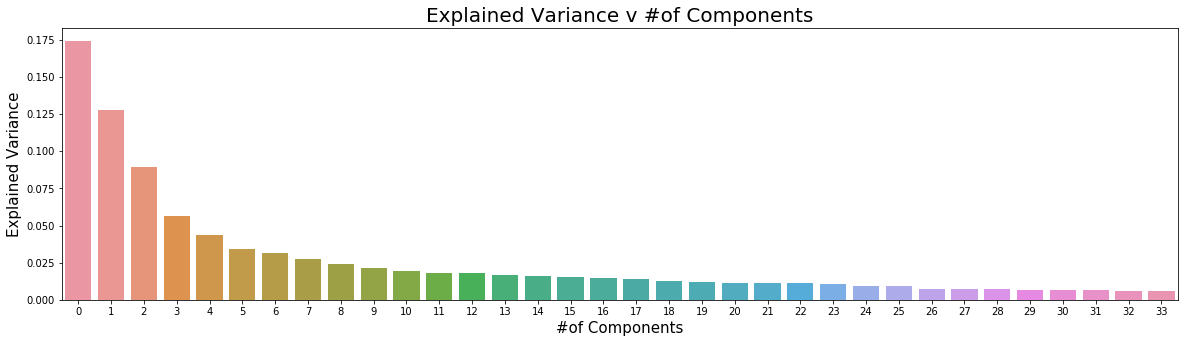

In [52]:
# Investigate the variance accounted for by each principal component.
evr = pca.explained_variance_ratio_
comps = np.arange(len(evr))
plt.figure(figsize=(20,5))
plt.title('Explained Variance v #of Components',fontsize=20)
plt.ylabel('Explained Variance',fontsize=15)
plt.xlabel('#of Components',fontsize=15)
sns.barplot(comps,evr);
print('Total explained variance: ', np.sum(evr))

13.033185720443726
Total explained variance:  0.787015962525


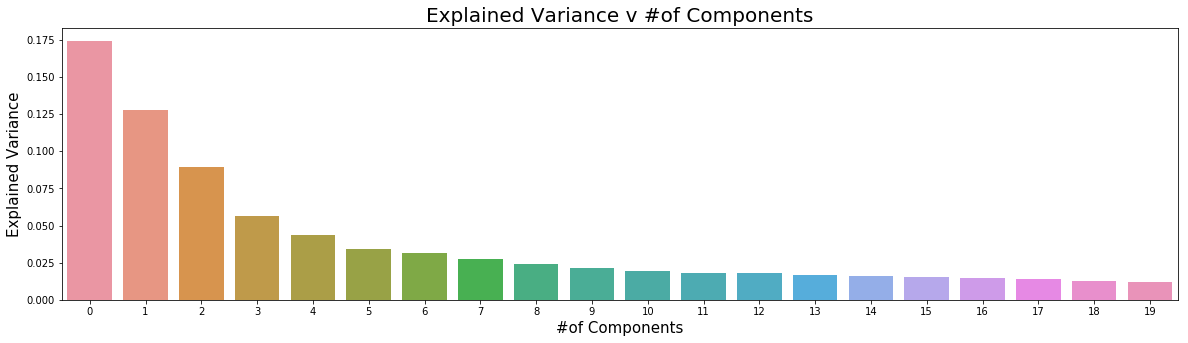

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
start = time.time()
pca = PCA(n_components=20)
pca.fit(scale_df)
print(time.time()-start)
evr = pca.explained_variance_ratio_
comps = np.arange(len(evr))
plt.figure(figsize=(20,5))
plt.title('Explained Variance v #of Components',fontsize=20)
plt.ylabel('Explained Variance',fontsize=15)
plt.xlabel('#of Components',fontsize=15)
sns.barplot(comps,evr);
print('Total explained variance: ', np.sum(evr))

### Discussion 2.2: Perform Dimensionality Reduction

I am retaining 34 of the components as it accounts for 90% of the variance in the data and the time difference in fitting the data to a smaller amount of components is not large.

In [54]:
pca = PCA(n_components=34,svd_solver='randomized', random_state=42)
fit_pca = pca.fit(scale_df)
evr = pca.explained_variance_ratio_
x_pca = fit_pca.transform(scale_df)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def weights(full_data,pca, num_comp):
    df = pd.DataFrame(pca.components_, columns=full_data.columns)
    #df.insert(0,'Explained Variance Ratio',evr) 
    weight = df.iloc[num_comp].sort_values(ascending=False)
    return weight
weights(clean_df,fit_pca,0)

PLZ8_ANTG3                        0.223998
PLZ8_ANTG4                        0.218502
PLZ8_BAUMAX                       0.214247
CAMEO_INTL_2015_WEALTH            0.201154
HH_EINKOMMEN_SCORE                0.197091
ORTSGR_KLS9                       0.195907
EWDICHTE                          0.193015
FINANZ_HAUSBAUER                  0.164539
PLZ8_ANTG2                        0.150733
KBA05_ANTG4                       0.150165
ARBEIT                            0.143007
ANZ_HAUSHALTE_AKTIV               0.133262
RELAT_AB                          0.132424
KBA05_ANTG3                       0.130596
FINANZ_SPARER                     0.114738
SEMIO_PFLICHT                     0.085479
SEMIO_REL                         0.082921
PRAEGENDE_JUGENDJAHRE_DECADES     0.071303
SEMIO_RAT                         0.070511
REGIOTYP                          0.067471
SEMIO_TRADV                       0.061788
SEMIO_MAT                         0.061119
SEMIO_FAM                         0.059995
O          

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights(clean_df,fit_pca,1)

ALTERSKATEGORIE_GROB             0.272026
FINANZ_VORSORGER                 0.243528
SEMIO_ERL                        0.235517
SEMIO_LUST                       0.190075
RETOURTYP_BK_S                   0.165179
W_KEIT_KIND_HH                   0.116112
SEMIO_KRIT                       0.112669
SEMIO_KAEM                       0.103009
FINANZ_MINIMALIST                0.095004
FINANZ_HAUSBAUER                 0.094082
ANREDE_KZ                        0.085314
EWDICHTE                         0.067035
ORTSGR_KLS9                      0.066210
WOHNDAUER_2008                   0.065435
PLZ8_ANTG3                       0.064778
SEMIO_DOM                        0.063962
PLZ8_ANTG4                       0.061894
PLZ8_BAUMAX                      0.057370
ARBEIT                           0.049375
KBA05_ANTG4                      0.048429
RELAT_AB                         0.046793
CAMEO_INTL_2015_WEALTH           0.045801
PLZ8_ANTG2                       0.044195
ANZ_HAUSHALTE_AKTIV              0

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(clean_df,fit_pca,2)

SEMIO_VERT                        0.347793
SEMIO_SOZ                         0.263343
SEMIO_FAM                         0.250239
SEMIO_KULT                        0.235039
FINANZ_MINIMALIST                 0.161604
RETOURTYP_BK_S                    0.106505
FINANZ_VORSORGER                  0.098273
W_KEIT_KIND_HH                    0.085726
ALTERSKATEGORIE_GROB              0.077574
SEMIO_REL                         0.071288
SEMIO_LUST                        0.063461
SEMIO_MAT                         0.055685
GREEN_AVANTGARDE                  0.054679
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.052788
PLZ8_BAUMAX                       0.043954
ORTSGR_KLS9                       0.043139
EWDICHTE                          0.041866
PLZ8_ANTG4                        0.041316
PLZ8_ANTG3                        0.040000
WOHNDAUER_2008                    0.033803
ARBEIT                            0.031833
RELAT_AB                          0.027715
PLZ8_ANTG2                        0.025529
KBA05_ANTG4

### Discussion 2.3: Interpret Principal Components

The first 3 principal components make up nearly 38% of all variance. Since they encapsulate a majority of data it could be possible to reduce the dimensionality of the problem even more. 

The first principal components increases most with decreasing MOBI_REGIO, which is a person's movement pattern from no movement to high movement.

The second principal component increases most with ALTERSKATEGORIE_GROB, which a person's estimated age based on given name analysis. It ranges from less than 30yrs to greater than 60yrs.

The third principal component increases most with decreasing ANREDE_KZ, which is a person's gender (male or female). 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

#Create KMeans models for differing cluster sizes and score them
centers = []
scores = []
start = time.time()
for i in range(3,11):
    
    model = KMeans(i, random_state=42)
    model.fit(x_pca)
    score = model.score(x_pca)
    
    centers.append(i)
    scores.append(np.abs(score))

print(time.time() - start)

528.5072259902954


In [59]:
centers,scores

([3, 4, 5, 6, 7, 8, 9, 10],
 [37646504.916058548,
  35500640.945480868,
  34160834.021675587,
  32867826.167072378,
  31765511.761268869,
  30925433.912818305,
  30221275.449009664,
  29511046.610742074])

In [60]:
#DO NOT RUN! this took 2932.2524321079254 seconds (48min)
#the output was saved in centers1,scores1 in the cell below
"""centers1 = []
scores1 = []
start = time.time()
for i in range(11,21):
    
    model = KMeans(i)
    model.fit(x_pca)
    score = model.score(x_pca)
    
    centers1.append(i)
    scores1.append(np.abs(score))

print(time.time() - start)""";

In [61]:
"""
#backup in-case you do not want to run clusters 3-10
centers = [3, 4,
  5,
  6,
  7,
  8,
  9,
  10]
scores = [37645610.358551838,
  35499876.416239105,
  34084445.695517465,
  32866331.131728992,
  31763434.559273444,
  30964723.885807496,
  30286942.213814456,
  29672295.276656903]
"""
centers1 = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
scores1 = [29204492.824087832,
 28514753.205722038,
 28212618.703088805,
 27738652.863602392,
 27294971.871803124,
 27240535.405527502,
 26628871.78647132,
 26377331.40371144,
 26023917.73454829,
 25922240.36063173]
centers.extend(centers1), scores.extend(scores1);


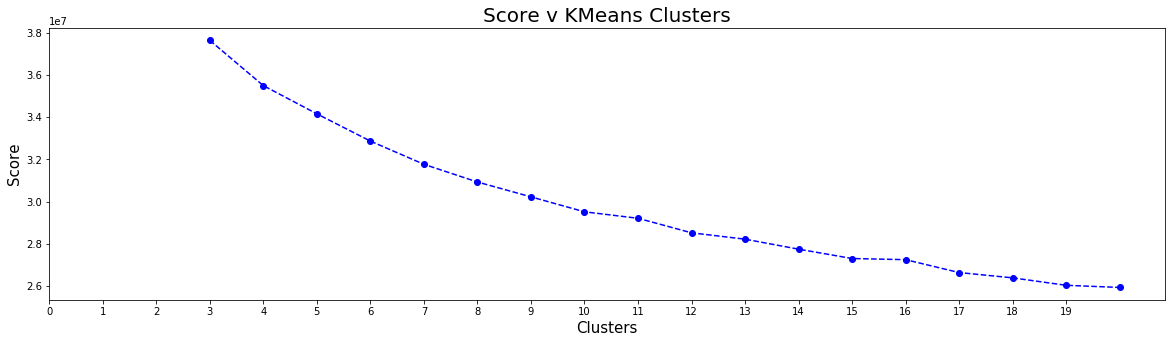

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(20,5))
plt.title('Score v KMeans Clusters',fontsize=20)
plt.xlabel('Clusters',fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xticks(np.arange(20));

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(10,random_state=42)
labels = model.fit_predict(x_pca)


### Discussion 3.1: Apply Clustering to General Population

The number of clusters selceted was 10 since after 10 it appears that the score does not decrease as quickly for the number of clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers = clean_data(customers)

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
impute_cust_df = pd.DataFrame(imp.transform(customers));
impute_cust_df.columns = customers.columns

scale_cust_df = pd.DataFrame(ss.transform(impute_cust_df))
scale_cust_df.columns = impute_cust_df.columns

x_cust_pca = pca.transform(scale_cust_df)

labels_cust = model.predict(x_cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

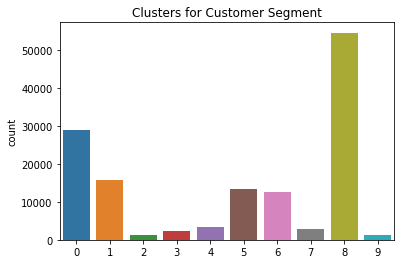

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.title('Clusters for Customer Segment')
sns.countplot(labels_cust);

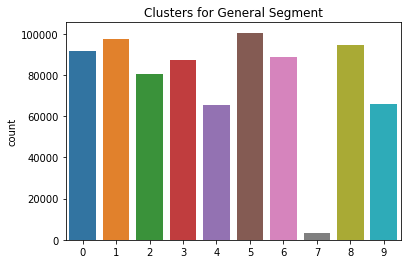

In [67]:
plt.title('Clusters for General Segment')
sns.countplot(labels);

## Underrepresented Clusters

Most clusters are underrepresented in the customer data when compared with the general population. 
The two most significant categories are cluster 6 & 7

SEMIO_VERT           0.347793
SEMIO_SOZ            0.263343
SEMIO_FAM            0.250239
SEMIO_KULT           0.235039
FINANZ_MINIMALIST    0.161604
SEMIO_RAT           -0.215939
SEMIO_KRIT          -0.275869
SEMIO_DOM           -0.313940
SEMIO_KAEM          -0.338761
ANREDE_KZ           -0.369321
Name: 2, dtype: float64

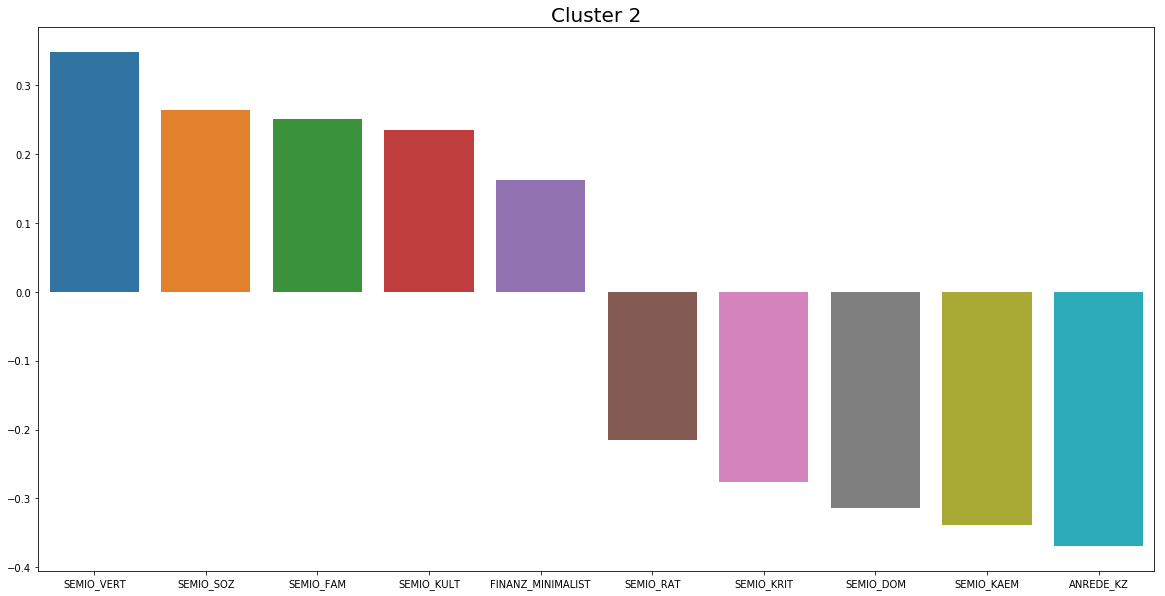

In [68]:
cluster_2 = pd.concat([weights(customers,pca,2).head(5),weights(customers,pca,2).tail(5)])
cluster_3 = pd.concat([weights(customers,pca,3).head(5),weights(customers,pca,3).tail(5)])
cluster_8 = pd.concat([weights(customers,pca,8).head(5),weights(customers,pca,8).tail(5)])

plt.figure(figsize=(20,10))
plt.title('Cluster 2',fontsize=20)
sns.barplot(cluster_2.index,cluster_2)
plt.ylabel('', fontsize=20)
plt.xticks(fontsize=10)
cluster_2


In [69]:
center2 = ss.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
center2 = pd.Series(data=center2, index=customers.columns)
center2[['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT',
       'FINANZ_MINIMALIST', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'ANREDE_KZ']]

SEMIO_VERT           2.202354
SEMIO_SOZ            3.245788
SEMIO_FAM            3.941929
SEMIO_KULT           4.120832
FINANZ_MINIMALIST    1.199142
SEMIO_RAT            6.122239
SEMIO_KRIT           5.477001
SEMIO_DOM            6.126540
SEMIO_KAEM           6.138890
ANREDE_KZ            2.004258
dtype: float64

SEMIO_VERT: The person has a very high affinity for dreamfullness. 

SEMIO_SOZ: The person has a high affinity for being socially minded.            

SEMIO_FAM: The person has an average affinity for being family minded.     

SEMIO_KULT: The person has an average affinity for being culturally minded.  

FINANZ_MINIMALIST: The person has an high affinity for being frugal.

SEMIO_RAT: The person has a very low affinity for being rational.  

SEMIO_KRIT: The person has a low affinity for being critically minded.  

SEMIO_DOM: The person has a very low affinity for being dominant minded.

SEMIO_KAEM: The person has a very low affinity for being combative minded. 

ANREDE_KZ: The person is a female. 

GREEN_AVANTGARDE                  0.347237
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.346918
EWDICHTE                          0.254768
ORTSGR_KLS9                       0.246669
LP_LEBENSPHASE_FEIN               0.194225
INNENSTADT                       -0.202494
KKK                              -0.203977
BALLRAUM                         -0.214748
HH_EINKOMMEN_SCORE               -0.217263
WOHNLAGE                         -0.264905
Name: 3, dtype: float64

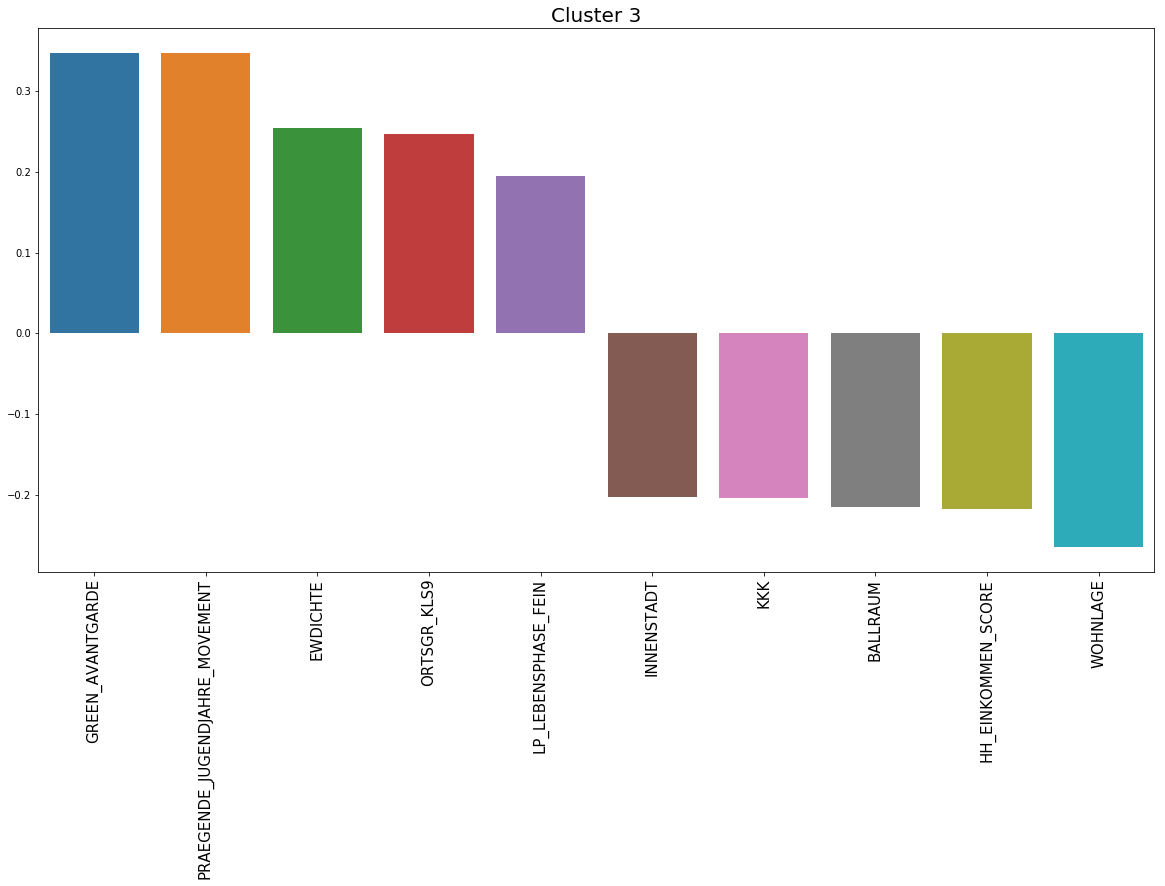

In [70]:
plt.figure(figsize=(20,10))
plt.title('Cluster 3',fontsize=20)
sns.barplot(cluster_3.index,cluster_3)
plt.ylabel('', fontsize=20)
plt.xticks(rotation='vertical',fontsize=15)
cluster_3

In [71]:
center3 = ss.inverse_transform(pca.inverse_transform(model.cluster_centers_[3]))
center3 = pd.Series(data=center3, index=customers.columns)
center3[['GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'EWDICHTE',
       'ORTSGR_KLS9', 'LP_LEBENSPHASE_FEIN', 'INNENSTADT', 'KKK', 'BALLRAUM',
       'HH_EINKOMMEN_SCORE', 'WOHNLAGE']]

GREEN_AVANTGARDE                   0.188773
PRAEGENDE_JUGENDJAHRE_MOVEMENT     0.201238
EWDICHTE                           3.039485
ORTSGR_KLS9                        4.057260
LP_LEBENSPHASE_FEIN               17.731997
INNENSTADT                         5.472351
KKK                                2.638125
BALLRAUM                           4.899726
HH_EINKOMMEN_SCORE                 4.118240
WOHNLAGE                           4.523753
dtype: float64

GREEN_AVANTGARDE: The person is not a member of green avantgarde.

PRAEGENDE_JUGENDJAHRE_MOVEMENT: This person was a part of the mainstream movement during their youth. 

EWDICHTE: There are 90 - 149 households per km^2.

ORTSGR_KLS9: There are 10,001 to  20,000 inhabitants in the community.

LP_LEBENSPHASE_FEIN: They are wealthy homeowner couples of younger age. 

INNENSTADT: They are 10 - 20 km to city center. 

KKK: They have average purchasing power. 

BALLRAUM: They are 40 -  50 km from an urban center. 

HH_EINKOMMEN_SCORE: They have an average income.

WOHNLAGE: They live in a very poor neighborhood. 

## Overrepresented Clusters

The only cluster that is overrepresented in the customer data when compared with the general
is cluster 8.

KBA05_ANTG2         0.254129
PLZ8_ANTG2          0.182719
W                   0.159115
SEMIO_MAT           0.149329
KBA05_ANTG3         0.149301
KBA13_ANZAHL_PKW   -0.242131
ARBEIT             -0.244949
PLZ8_HHZ           -0.296953
REGIOTYP           -0.350359
KKK                -0.361209
Name: 8, dtype: float64

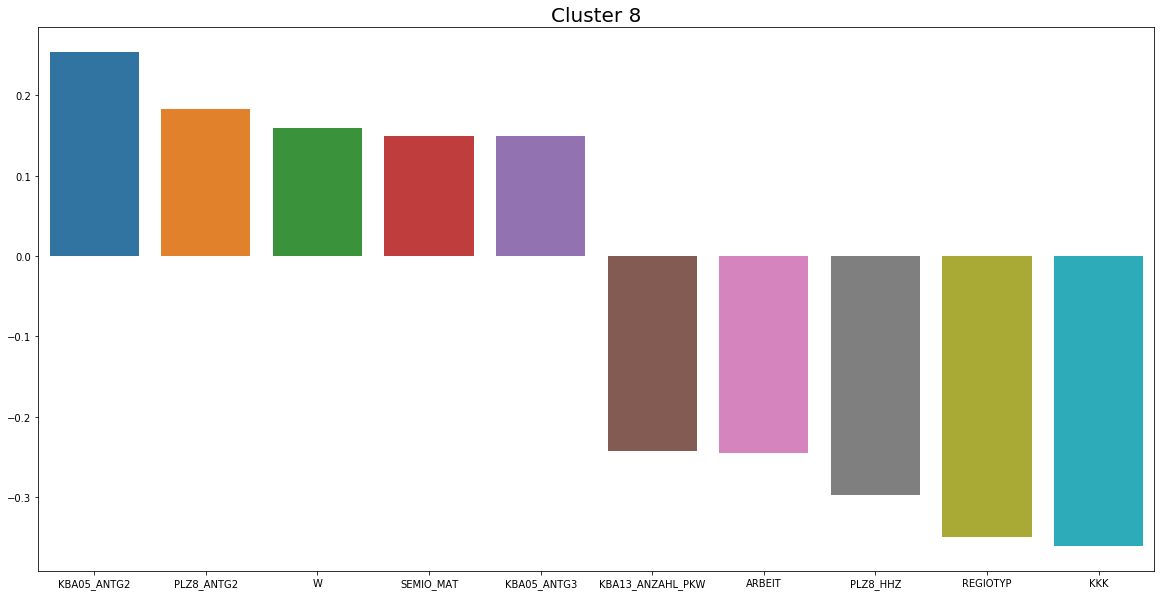

In [72]:
plt.figure(figsize=(20,10))
plt.title('Cluster 8',fontsize=20)
plt.xlabel('',fontsize=20)
sns.barplot(cluster_8.index,cluster_8)
plt.ylabel('', fontsize=20)
plt.xticks(fontsize=10)
cluster_8

In [73]:
center8 = ss.inverse_transform(pca.inverse_transform(model.cluster_centers_[8]))
center8 = pd.Series(data=center8, index=customers.columns)
center8[['KBA05_ANTG2', 'PLZ8_ANTG2', 'W', 'SEMIO_MAT', 'KBA05_ANTG3',
       'KBA13_ANZAHL_PKW', 'ARBEIT', 'PLZ8_HHZ', 'REGIOTYP', 'KKK']]

KBA05_ANTG2           1.086701
PLZ8_ANTG2            2.579353
W                     0.907306
SEMIO_MAT             3.121497
KBA05_ANTG3           0.068573
KBA13_ANZAHL_PKW    701.326910
ARBEIT                3.044829
PLZ8_HHZ              3.728215
REGIOTYP              3.514159
KKK                   2.174360
dtype: float64

KBA05_ANTG2: There is a lower share of 3-5 family homes in their microcell.

PLZ8_ANTG2: There is an average share of 3-5 family homes in their PLZ8 region. 

W: This person is in former West Germany. 

SEMIO_MAT: These people have a high affinity for being materialistic. 

KBA05_ANTG3: There are no 6-10 family homes.

KBA13_ANZAHL_PKW: There are 701.326910 cars in the region. 

ARBEIT: There is a low share of unemployment in community.

PLZ8_HHZ: There are 600-849 households in the PLZ8 region.

REGIOTYP: The neighborhood is middle class.

KKK: There is high purchasing power in the area. 

In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Most clusters are underrepresented in the customer data when compared with the general population. 
#The two most significant categories are cluster 6 & 7

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#The only cluster that is overrepresented in the customer data when compared with the general
#is cluster 8.

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Underrepresented:
The data represented positively in thes clusters can show areas of potential growth for the company as the cluster is unpopular, and a potential way to reach new customers would be to exploit the largest areas of growth in these clusters.

- SEMIO_VERT: Degree of dreamful perosonality typology (Positive affiliation)
- ANREDE_KZ: Gender (male or female) (Negative affiliation)

- GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth (Positive affiliation)
- PRAEGENDE_JUGENDJAHRE_MOVEMENT: Dominating movement of person's youth (avantgarde vs. mainstream) (Positive affiliation)
- WOHNLAGE: Neighborhood quality (Negative affiliation)

The conclusions for their underrepresented population are interesting. It seems that is is important to know people's personality, environmental sustainability affiliation and if they were more mainstream or avantgarde. While it is less important to consider someone's gender or neighborhood quality. 

##### Cluster 2:
- SEMIO_VERT           0.347793
- SEMIO_SOZ            0.263343
- SEMIO_FAM            0.250239
- SEMIO_KULT           0.235039
- FINANZ_MINIMALIST    0.161604
- SEMIO_RAT           -0.215939
- SEMIO_KRIT          -0.275869
- SEMIO_DOM           -0.313940
- SEMIO_KAEM          -0.338761
- ANREDE_KZ           -0.369321

##### Cluster 3:
- GREEN_AVANTGARDE                  0.347237
- PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.346918
- EWDICHTE                          0.254768
- ORTSGR_KLS9                       0.246669
- LP_LEBENSPHASE_FEIN               0.194225
- INNENSTADT                       -0.202494
- KKK                              -0.203977
- BALLRAUM                         -0.214748
- HH_EINKOMMEN_SCORE               -0.217263
- WOHNLAGE                         -0.264905

#### Overrepresented:
The data represented positively in thes clusters can show areas that the company is doing well in and can continue to succeed in. 

- KBA05_ANTG2: Number of 3-5 family houses in the microcell (Positive affiliation)
- REGIOTYP: Neighborhood typology (Negative affiliation)
- KKK: Purchasing power in region (Negative affiliation)

The overrepresented cluster seems to place importance on the number of 3-5 family houses in a microcell. The less important features were the neighborhood typology and the purchasing power in the region. 

##### Cluster 8: 

- KBA05_ANTG2         0.254129
- PLZ8_ANTG2          0.182719
- W                   0.159115
- SEMIO_MAT           0.149329
- KBA05_ANTG3         0.149301
- KBA13_ANZAHL_PKW   -0.242131
- ARBEIT             -0.244949
- PLZ8_HHZ           -0.296953
- REGIOTYP           -0.350359
- KKK                -0.361209

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.